# Homework 2

This Notebook will detail Homework 2, which involves a basic capacity expansion model formulation described in [Notebook 3](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks)

First, load (or install if necessary) a set of packages you'll need for this assignment...

In [1]:
# Uncomment and run this first line if you need to install or update packages
#import Pkg; Pkg.add("JuMP"); Pkg.add("HiGHS"); Pkg.add("DataFrames"); Pkg.add("CSV")
using JuMP
using HiGHS
using DataFrames
using CSV
using Plots

### Question 1 - Build the basic thermal generation expansion model

Using the example model in [Notebook 3](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks) as your guide, input the code to create a basic thermal generator capacity expansion model, including [downloading the data for Notebook 3 here](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks/expansion_data) and loading the appropriate csv files.

In [2]:
generators = DataFrame(CSV.File("expansion_data/generators_for_expansion.csv"))
#copied the folder into this directory

Row,G,Description,Capex,FixedOM,VarOM,HeatRate,FuelCost,WACC,AssetLife,CRF,Annuity,FixedCost,VarCost
,String7,String31,Int64,Int64,Int64,Float64,Int64,Float64,Int64,Float64,Int64,Int64,Float64
1,Geo,Geothermal,7500000,130000,0,28.4,0,0.04,30,0.0578,433500,563500,0.0
2,Coal,Supercritical Coal,2600000,120000,8,8.1,2,0.04,30,0.0578,150280,270280,24.2
3,CCGT,Natural gas CCGT,1000000,28000,2,6.4,4,0.035,30,0.0544,54400,82400,27.6
4,CT,Natural gas CT,770000,21000,5,9.7,4,0.035,30,0.0544,41888,62888,43.8
5,Wind,Onshore wind,1000000,40000,0,1.0,0,0.03,30,0.051,51000,91000,0.0
6,Solar,Tracking solar PV,750000,15000,0,1.0,0,0.025,30,0.0478,35850,50850,0.0


In [3]:
demand = DataFrame(CSV.File("expansion_data/demand_for_expansion.csv"))

Row,Hour,Demand
,Int64,Int64
1,1,2274
2,2,2581
3,3,2576
4,4,2482
5,5,2396
6,6,2193
7,7,1929
8,8,1715
9,9,1555


## Question 2: Analytical solution

**A.** Using the data provided above, sort the demand data from highest to lowest hours to create a load duration curve and save this as a vector/array/DataFrame of your choice.

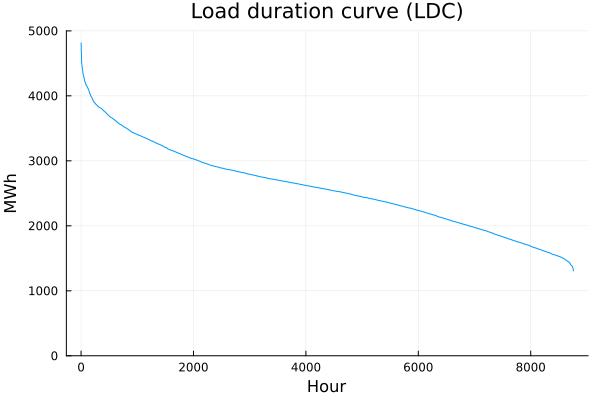

In [4]:
sorted_demand = sort(demand.Demand, rev=true)
plot(sorted_demand, ylims=(0,5000), label="")
title!("Load duration curve (LDC)")
xaxis!("Hour")
yaxis!("MWh")

**B.** Now using the cost data provided in '/generators_for_expansion.csv' and the load duration curve above, use the formulas provided in Lecture to determine an analytical solution to the optimal thermal generation expansion decisions (e.g. solve it algebraically rather than use an optimization solver to find the solution). 

Report the optimal capacity of each generation source and compare to the solution from the optimization model above. 

Show your work in cells below, using Julia to perform calculations. Explain your steps using inline code comments (e.g. `# Comment`) or by interspersing Markdown cells.  

Tip: round your solutions for the crossover hour between each technology to the nearest integer (as we have discrete hours in the time series).

In [5]:
function equation(x,m,k)
    return (m*x)+k
end

equation (generic function with 1 method)

In [6]:
fixed_cost = []
#intercept
a = (generators.FixedCost[1:(size(generators,1)-2)])/8760
#slope
b = generators.VarCost[1:(size(generators,1)-2)]
    x = 0:1

0:1

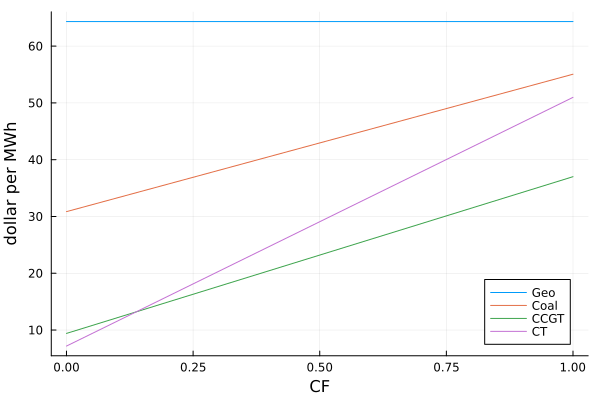

In [7]:
plot(x, equation.(x, b[1], a[1]), label="Geo")
plot!(x, equation.(x, b[2], a[2]), label="Coal")
plot!(x, equation.(x, b[3], a[3]), label="CCGT")
plot!(x, equation.(x, b[4], a[4]), label="CT")
xaxis!("CF")
yaxis!("dollar per MWh")


In [8]:
#now we can see that only CCGT and CT seem to viable option for these system

#finding the intersection
x_intersect = trunc(Int, round(((a[4]-a[3])/(b[3]-b[4]))*8760))


1204

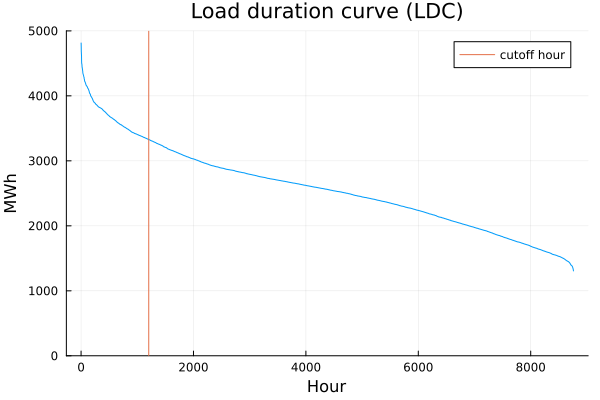

In [9]:
#replotting the load demand curve with the x-intersect from the cost graph
sorted_demand = sort(demand.Demand, rev=true)
plot(sorted_demand, ylims=(0,5000), label="")
title!("Load duration curve (LDC)")
xaxis!("Hour")
yaxis!("MWh")

#plotting the ln
line_x =[x_intersect, x_intersect]
line_y = [0, 5000]
plot!(line_x, line_y, label="cutoff hour")

In [10]:
#finding the demand at the cutoff hour
sorted_demand[x_intersect]

3328

**ANS** Based on the graphs and the computed solutions with intersection, we can conclude that it would be economical to use CCGT generator for 3328 MWh capacity and the remaining can be covered by the CT generator. This result tallies with the optimization solver that was done in notebook 3.

**C.** Now change the fuel cost of natural gas to \$8.00/MMBtu, recalculate the variable cost of CCGTs and CTs, and solve again for the optimal generation capacity mix. Describe what changes in your capacity results and what doesn't, and provide an explanation.

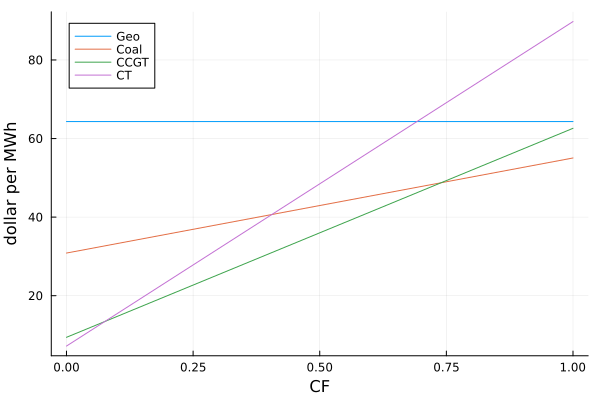

In [11]:
varcost_ccgt = generators[generators.G.=="CCGT",:VarOM][1] + (generators[generators.G.=="CCGT",:HeatRate][1] * 8)
varcost_ct = generators[generators.G.=="CT",:VarOM][1] + (generators[generators.G.=="CT",:HeatRate][1] * 8)

plot(x, equation.(x, b[1], a[1]), label="Geo")
plot!(x, equation.(x, b[2], a[2]), label="Coal")
plot!(x, equation.(x, varcost_ccgt, a[3]), label="CCGT")
plot!(x, equation.(x, varcost_ct, a[4]), label="CT")
xaxis!("CF")
yaxis!("dollar per MWh")
#show(varcost_ccgt)


In [12]:
#now we can see that there are two intersections for with coal and CT along wiht coal and CCGT
#finding the intersection for the first point
x_intersect1 = trunc(Int, round(((a[3]-a[4])/(varcost_ct-varcost_ccgt))*8760))
x_intersect2 = trunc(Int, round(((a[3]-a[2])/(b[2]-varcost_ccgt))*8760))

6479

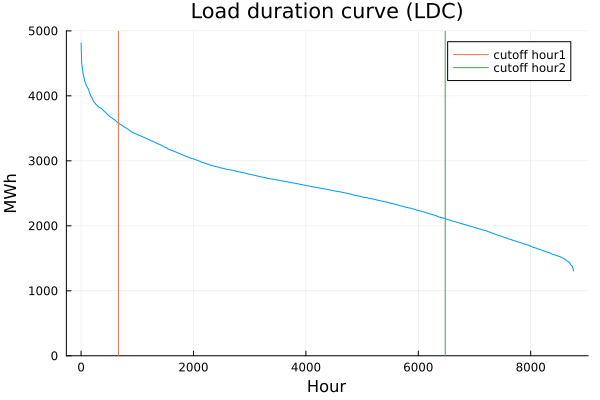

In [13]:
#replotting the load demand curve with the x-intersect from the cost graph
sorted_demand = sort(demand.Demand, rev=true)
plot(sorted_demand, ylims=(0,5000), label="")
title!("Load duration curve (LDC)")
xaxis!("Hour")
yaxis!("MWh")

#plotting the ln
line_x1 = [x_intersect1, x_intersect1]
line_x2 = [x_intersect2, x_intersect2]
line_y = [0, 5000]
plot!(line_x1, line_y, label="cutoff hour1")
plot!(line_x2, line_y, label="cutoff hour2")

In [14]:
sorted_demand[x_intersect1]

3582

In [15]:
sorted_demand[x_intersect2]

2110

In [16]:
sorted_demand[x_intersect1]-sorted_demand[x_intersect2]

1472

**ANS** Based on the graphs and computed solutions with 2 intersections, we can conclude that it would be more economical to use coal for 2110MWh, CCGT for 1472MWH and CT for the remaining demand load.

Compared to the previous one, the coal has a higher share of generation capacity compared to CCGT and CT which would intuitively make sense as the price of natural gas increased, the variable cost for CCGT and CT increased, making the coal generator cheaper to be included in the system.

## Question 3 - Expansion with renewables

**A.** Using JuMP/Julia, implement an optimization model based on the formulation for optimal thermal+renewable capacity expansion provided in Section 2 of [Notebook 3](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks). 

In [17]:
#The set of generators from generators DataFrame
G = generators.G[1:(size(generators,1))]
print(G)
#The set of thermal generators
Gte = generators.G[1:size(generators,1)-2]
print(Gte)
#The set of renewable energy generators
Gwind = generators.G[size(generators,1)-1:size(generators,1)-1]
print(Gwind)
Gsolar = generators.G[size(generators,1):size(generators,1)]
print(Gsolar)
#The set of hours in the demand DataFrame
H = demand.Hour;

String7["Geo", "Coal", "CCGT", "CT", "Wind", "Solar"]String7["Geo", "Coal", "CCGT", "CT"]String7["Wind"]String7["Solar"]

In [18]:
#defining the model
Expansion_renewable_model = Model(HiGHS.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS

In [19]:
variability = DataFrame(CSV.File("expansion_data/wind_solar_for_expansion.csv"))

Row,Hour,Wind,Solar
,Int64,Float64,Float64
1,1,0.0296442,0.440206
2,2,0.0534046,0.0
3,3,0.0456225,0.0
4,4,0.0908019,0.0
5,5,0.177524,0.0
6,6,0.196106,0.0
7,7,0.163481,0.0
8,8,0.129312,0.0
9,9,0.131448,0.0


In [20]:
@variables(Expansion_renewable_model, begin
        CAP[g in G] >= 0          #Generating capacity built (MW)
        GEN[g in G, h in H] >= 0  #Generation in each hour (MWh)
        NSE[h in H] >= 0          #Non-served energy in each hour (MWh)
    end)

(1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, String7["Geo", "Coal", "CCGT", "CT", "Wind", "Solar"]
And data, a 6-element Vector{VariableRef}:
 CAP[Geo]
 CAP[Coal]
 CAP[CCGT]
 CAP[CT]
 CAP[Wind]
 CAP[Solar], 2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, String7["Geo", "Coal", "CCGT", "CT", "Wind", "Solar"]
    Dimension 2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760]
And data, a 6×8760 Matrix{VariableRef}:
 GEN[Geo,1]    GEN[Geo,2]    …  GEN[Geo,8759]    GEN[Geo,8760]
 GEN[Coal,1]   GEN[Coal,2]      GEN[Coal,8759]   GEN[Coal,8760]
 GEN[CCGT,1]   GEN[CCGT,2]      GEN[CCGT,8759]   GEN[CCGT,8760]
 GEN[CT,1]     GEN[CT,2]        GEN[CT,8759]     GEN[CT,8760]
 GEN[Wind,1]   GEN[Wind,2]      GEN[Wind,8759]   GEN[Wind,8760]
 GEN[Solar,1]  GEN[Solar,2]  …  GEN[Solar,8759]  GEN[Solar,8760], 1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, [1

In [21]:
@constraints(Expansion_renewable_model, begin
        cDemandBalance[h in H], sum(GEN[g,h] for g in G) + NSE[h] == demand.Demand[h]
        cCapacity_Thermal[g in Gte, h in H], GEN[g,h] <= CAP[g]
        cCapacity_Wind[g in Gwind, h in H], GEN[g,h] <= CAP[g] * variability.Wind[h]
        cCapacity_Solar[g in Gsolar, h in H], GEN[g,h] <= CAP[g] * variability.Solar[h] 
    end)

(1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760]
And data, a 8760-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 cDemandBalance[1] : GEN[Geo,1] + GEN[Coal,1] + GEN[CCGT,1] + GEN[CT,1] + GEN[Wind,1] + GEN[Solar,1] + NSE[1] = 2274
 cDemandBalance[2] : GEN[Geo,2] + GEN[Coal,2] + GEN[CCGT,2] + GEN[CT,2] + GEN[Wind,2] + GEN[Solar,2] + NSE[2] = 2581
 cDemandBalance[3] : GEN[Geo,3] + GEN[Coal,3] + GEN[CCGT,3] + GEN[CT,3] + GEN[Wind,3] + GEN[Solar,3] + NSE[3] = 2576
 cDemandBalance[4] : GEN[Geo,4] + GEN[Coal,4] + GEN[CCGT,4] + GEN[CT,4] + GEN[Wind,4] + GEN[Solar,4] + NSE[4] = 2482
 cDemandBalance[5] : GEN[Geo,5

In [22]:
NSECost = 9000

9000

In [23]:
#objective function
@objective(Expansion_renewable_model, Min,
    sum(generators[generators.G.==g,:FixedCost][1]*CAP[g] +
        sum(generators[generators.G.==g,:VarCost][1]*GEN[g,h] for h in H)
    for g in G) + 
    sum(NSECost*NSE[h] for h in H)
);

**B.** Solve the model to determine the optimal capacity when wind and solar are available resources and extract results for generation and capacity.

In [24]:
Expansion_renewable_model

A JuMP Model
Minimization problem with:
Variables: 61326
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 8760 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 52560 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 61326 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: CAP, GEN, NSE, cCapacity_Solar, cCapacity_Thermal, cCapacity_Wind, cDemandBalance

In [25]:
optimize!(Expansion_renewable_model)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
56856 rows, 56862 cols, 153048 nonzeros
56856 rows, 56862 cols, 153048 nonzeros
Presolve : Reductions: rows 56856(-4464); columns 56862(-4464); elements 153048(-8928)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(6.18517e+06) 0s
      40370     8.2899893531e+08 Pr: 0(0) 4s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 40370
Objective value     :  8.2899893531e+08
HiGHS run time      :          4.93


In [26]:
value.(CAP).data

6-element Vector{Float64}:
    0.0
    0.0
 2422.855352805202
 1419.7834328744516
  349.95573041870074
 3362.7680693765346

In [27]:
# Record generation capacity and energy results
generation = zeros(size(G,1))
for i in 1:size(G,1) 
    generation[i] = sum(value.(GEN)[G[i],:].data) 
end
MWh_share = generation./sum(demand.Demand).*100
cap_share = value.(CAP).data./maximum(demand.Demand).*100
results = DataFrame(
    Resource = G, 
    MW = value.(CAP).data,
    Percent_MW = cap_share,
    GWh = generation/1000,
    Percent_GWh = MWh_share
)
# Calculate how much non-served energy there was and add to results
  # The maximum MW of non-served energy is the difference 
  # between peak demand and total installed generation capacity
NSE_MW = maximum(value.(NSE).data) 
  # The total MWh of non-served energy is the difference between
  # total demand and total generation
NSE_MWh = sum(value.(NSE).data)
  # Add or "push" a new row of data to the end of the results DataFrame
push!(results, ["NSE" NSE_MW NSE_MW/maximum(demand.Demand)*100 NSE_MWh/1000 NSE_MWh/sum(demand.Demand)*100])

Row,Resource,MW,Percent_MW,GWh,Percent_GWh
,String7,Float64,Float64,Float64,Float64
1,Geo,0.0,0.0,0.0,0.0
2,Coal,0.0,0.0,0.0,0.0
3,CCGT,2422.86,50.3398,11367.7,50.3709
4,CT,1419.78,29.4989,453.98,2.01162
5,Wind,349.956,7.27105,1007.7,4.46518
6,Solar,3362.77,69.8684,9738.16,43.1505
7,NSE,136.513,2.83635,0.399328,0.00176945


**C.** What happens to the total firm generation and maximum MW of non-served energy? What does this imply about the capacity value of solar and/or wind built in the optimal capacity mix?

**ANS** The total firm generation has increased a lot compared to the expansion model with just the thermal generators. This implies that building solar and wind within the optimal capacity mix would increase the total generation while keeping the costs low as the renewable energy generators do not have any variable costs compared to the thermal generators.

## Question 4: Brownfield Expansion Model

**A.** Now implement an optimization model based on the formulation for optimal "brownfield" thermal+renewable capacity expansion (e.g. with existing generators) provided in Section 3 of [Notebook 3](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks).

Use the following data for fixed and variable costs of existing gas capacity. Note: unlike in the formulation in Notebook 3, there is no existing renewable capacity here to consider (only thermal).

In [28]:
# Load new generator options
#path = joinpath([REPLACE THIS WITH PATH TO YOUR power-systems-optimization DIRECTORY HERE],"Notebooks","expansion_data")
path = joinpath("/Users/kaarthigeswaranagnapathy/Documents/GitHub/power-systems-optimization","Notebooks","expansion_data")
# Add parameters for existing CCGTs, with the set index "Old"
push!(generators, ["Old_CC" "Existing CCGT" 0 40000 5 7.5 4 0 0 0 0 40000 30])
# Add parameters for existing CTs, with the set index "Old"
push!(generators, ["Old_CT" "Existing CT" 0 30000 11 11.0 4 0 0 0 0 30000 55])

# Set installed capacity for existing CCGTs:
ExistingCap_CCGT = 1260 # Approximate actual existing capacity in SDGE
ExistingCap_CT = 925 # Approximate actual existing capacity in SDGE
# Add new column to generators Data Frame
generators[!,:ExistingCap] = [0,0,0,0,0,0, ExistingCap_CCGT, ExistingCap_CT];



In [29]:
generators

Row,G,Description,Capex,FixedOM,VarOM,HeatRate,FuelCost,WACC,AssetLife,CRF,Annuity,FixedCost,VarCost,ExistingCap
,String7,String31,Int64,Int64,Int64,Float64,Int64,Float64,Int64,Float64,Int64,Int64,Float64,Int64
1,Geo,Geothermal,7500000,130000,0,28.4,0,0.04,30,0.0578,433500,563500,0.0,0
2,Coal,Supercritical Coal,2600000,120000,8,8.1,2,0.04,30,0.0578,150280,270280,24.2,0
3,CCGT,Natural gas CCGT,1000000,28000,2,6.4,4,0.035,30,0.0544,54400,82400,27.6,0
4,CT,Natural gas CT,770000,21000,5,9.7,4,0.035,30,0.0544,41888,62888,43.8,0
5,Wind,Onshore wind,1000000,40000,0,1.0,0,0.03,30,0.051,51000,91000,0.0,0
6,Solar,Tracking solar PV,750000,15000,0,1.0,0,0.025,30,0.0478,35850,50850,0.0,0
7,Old_CC,Existing CCGT,0,40000,5,7.5,4,0.0,0,0.0,0,40000,30.0,1260
8,Old_CT,Existing CT,0,30000,11,11.0,4,0.0,0,0.0,0,30000,55.0,925


In [30]:
G = generators.G[1:(size(generators,1))]
print(G)

Gnew = generators.G[1:(size(generators,1)-2)]
print(Gnew)

#new thermal generators
Gte = generators.G[1:(size(generators,1)-4)]
print(Gte)

#existing old thermal generators
Gold = generators.G[(size(generators,1)-1):size(generators,1)]
print(Gold)

#renewable energy generators
Gwind = generators.G[size(generators,1)-3:size(generators,1)-3]
print(Gwind)
Gsolar = generators.G[size(generators,1)-2:size(generators,1)-2]
print(Gsolar)


String7["Geo", "Coal", "CCGT", "CT", "Wind", "Solar", "Old_CC", "Old_CT"]String7["Geo", "Coal", "CCGT", "CT", "Wind", "Solar"]String7["Geo", "Coal", "CCGT", "CT"]String7["Old_CC", "Old_CT"]String7["Wind"]String7["Solar"]

In [31]:
Expansion_brownfield_model = Model(HiGHS.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS

In [32]:
@variables(Expansion_brownfield_model, begin
        CAP[g in Gnew] >= 0
        GEN[g in G, h in H] >= 0
        RET[g in Gold] >= 0
        NSE[h in H] >= 0
    end)

(1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, String7["Geo", "Coal", "CCGT", "CT", "Wind", "Solar"]
And data, a 6-element Vector{VariableRef}:
 CAP[Geo]
 CAP[Coal]
 CAP[CCGT]
 CAP[CT]
 CAP[Wind]
 CAP[Solar], 2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, String7["Geo", "Coal", "CCGT", "CT", "Wind", "Solar", "Old_CC", "Old_CT"]
    Dimension 2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760]
And data, a 8×8760 Matrix{VariableRef}:
 GEN[Geo,1]     GEN[Geo,2]     …  GEN[Geo,8759]     GEN[Geo,8760]
 GEN[Coal,1]    GEN[Coal,2]       GEN[Coal,8759]    GEN[Coal,8760]
 GEN[CCGT,1]    GEN[CCGT,2]       GEN[CCGT,8759]    GEN[CCGT,8760]
 GEN[CT,1]      GEN[CT,2]         GEN[CT,8759]      GEN[CT,8760]
 GEN[Wind,1]    GEN[Wind,2]       GEN[Wind,8759]    GEN[Wind,8760]
 GEN[Solar,1]   GEN[Solar,2]   …  GEN[Solar,8759]   GEN[Solar,8760]
 GEN[Old_CC,1]  GEN[Old_CC,2]     GEN[Old_CC,87

In [33]:
@constraints(Expansion_brownfield_model, begin
        cDemandBalance[h in H], sum(GEN[g,h] for g in G) + NSE[h] == demand.Demand[h]
        cCapacityNew[g in Gte, h in H], GEN[g,h] <= CAP[g]
        cCapacity_Wind[g in Gwind, h in H], GEN[g,h] <= CAP[g] * variability.Wind[h]
        cCapacity_Solar[g in Gsolar, h in H], GEN[g,h] <= CAP[g] * variability.Solar[h]
        cCapacityOld[g in Gold, h in H], GEN[g,h] <= generators[generators.G.==g,:ExistingCap][1] - RET[g]
    end)

(1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760]
And data, a 8760-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 cDemandBalance[1] : GEN[Geo,1] + GEN[Coal,1] + GEN[CCGT,1] + GEN[CT,1] + GEN[Wind,1] + GEN[Solar,1] + GEN[Old_CC,1] + GEN[Old_CT,1] + NSE[1] = 2274
 cDemandBalance[2] : GEN[Geo,2] + GEN[Coal,2] + GEN[CCGT,2] + GEN[CT,2] + GEN[Wind,2] + GEN[Solar,2] + GEN[Old_CC,2] + GEN[Old_CT,2] + NSE[2] = 2581
 cDemandBalance[3] : GEN[Geo,3] + GEN[Coal,3] + GEN[CCGT,3] + GEN[CT,3] + GEN[Wind,3] + GEN[Solar,3] + GEN[Old_CC,3] + GEN[Old_CT,3] + NSE[3] = 2576
 cDemandBalance[4] : GEN[Geo,4] + GEN[Coal,4] + GEN

In [34]:
#objective function
@objective(Expansion_brownfield_model, Min,
    sum(generators[generators.G.==g,:FixedCost][1]*CAP[g] for g in Gnew) + 
    sum((generators[generators.G.==g,:FixedCost][1])*(generators[generators.G.==g,:ExistingCap][1] - RET[g]) for g in Gold) +
    sum(generators[generators.G.==g,:VarCost][1]*GEN[g,h] for h in H, g in G) + 
    sum(NSECost*NSE[h] for h in H) 
);

**B.** Solve the model to determine the optimal capacity when with existing generators and extract results for generation and capacity (including retirements).

In [35]:
Expansion_brownfield_model

A JuMP Model
Minimization problem with:
Variables: 78848
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 8760 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 70080 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 78848 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: CAP, GEN, NSE, RET, cCapacityNew, cCapacityOld, cCapacity_Solar, cCapacity_Wind, cDemandBalance

In [36]:
optimize!(Expansion_brownfield_model)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
74376 rows, 74384 cols, 205608 nonzeros
74376 rows, 74384 cols, 205608 nonzeros
Presolve : Reductions: rows 74376(-4464); columns 74384(-4464); elements 205608(-8928)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -6.9996425545e+04 Ph1: 17520(10432); Du: 2(69996.4) 0s
      41109     7.3427860717e+08 Pr: 11824(2.93798e+06); Du: 0(7.5929e-08) 5s
      46448     7.5484786586e+08 Pr: 344(3425); Du: 0(1.22619e-07) 10s
      46752     7.5494110973e+08 Pr: 0(0); Du: 0(1.691e-11) 10s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 46752
Objective value     :  7.5494110973e+08
HiGHS run time      :         10.98


In [37]:
value.(RET)
value.(CAP)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, String7["Geo", "Coal", "CCGT", "CT", "Wind", "Solar"]
And data, a 6-element Vector{Float64}:
    0.0
    0.0
 1417.3111862078852
  238.5552078805265
  385.04456371323397
 3357.6194310281

In [38]:
# Record generation capacity and energy results for thermal generators
generation = zeros(size(Gnew,1))
for i in 1:size(Gnew,1) 
    generation[i] = sum(value.(GEN)[Gnew[i],:].data) 
end
MWh_share = generation./sum(demand.Demand).*100
cap_share = value.(CAP).data./maximum(demand.Demand).*100
results = DataFrame(
    Resource = Gnew, 
    MW = value.(CAP).data,
    Percent_MW = cap_share,
    GWh = generation/1000,
    Percent_GWh = MWh_share
)

# Record generation capacity and energy results for thermal generators
generation = zeros(size(Gold,1))
for i in 1:size(Gold,1) 
    generation[i] = sum(value.(GEN)[Gold[i],:].data) 
end
MWh_share = generation./sum(demand.Demand).*100
ret_share = value.(RET).data./maximum(demand.Demand).*100
results1 = DataFrame(
    Resource = Gold, 
    RET_MW = value.(RET).data,
    RET_Percent_MW = ret_share,
    GWh = generation/1000,
    Percent_GWh = MWh_share
)

# Calculate how much non-served energy there was and add to results
  # The maximum MW of non-served energy is the difference 
  # between peak demand and total installed generation capacity
NSE_MW = maximum(value.(NSE).data) 
  # The total MWh of non-served energy is the difference between
  # total demand and total generation
NSE_MWh = sum(value.(NSE).data)
  # Add or "push" a new row of data to the end of the results DataFrame
push!(results, ["NSE" NSE_MW NSE_MW/maximum(demand.Demand)*100 NSE_MWh/1000 NSE_MWh/sum(demand.Demand)*100])

show(results)

show(results1)

7×5 DataFrame
 Row │ Resource  MW        Percent_MW  GWh          Percent_GWh 
     │ String7   Float64   Float64     Float64      Float64     
─────┼──────────────────────────────────────────────────────────
   1 │ Geo          0.0       0.0         0.0        0.0
   2 │ Coal         0.0       0.0         0.0        0.0
   3 │ CCGT      1417.31     29.4476   8545.01      37.8636
   4 │ CT         238.555     4.95648   105.948      0.469465
   5 │ Wind       385.045     8.00009  1111.66       4.92586
   6 │ Solar     3357.62     69.7615   9717.89      43.0607
   7 │ NSE        125.066     2.5985      0.366094   0.001622192×5 DataFrame
 Row │ Resource  RET_MW   RET_Percent_MW  GWh       Percent_GWh 
     │ String7   Float64  Float64         Float64   Float64     
─────┼──────────────────────────────────────────────────────────
   1 │ Old_CC        0.0             0.0  2973.4      13.1754
   2 │ Old_CT        0.0             0.0   113.611     0.503418